## 3 - Data Science 
The following public data-set shows for a range of years, the bankruptcy predictions of Polish companies.  
Objective: Fit a model to evaluate the probability of bankruptcy after 4 years.  
a) Do the data pipeline (download, cleansing, convert formats if needed, etc)

b) Explain and justify decisions from point a)

c) Model classification 

d) Explain and justify decisions from point c)

In [1]:
#!pip install numpy pandas sklearn imblearn seaborn 

Importing the needed libraries

In [2]:
#For data handling
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer as Imputer

#Visualization
pd.options.display.max_rows = 30
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
from sklearn import metrics

#Models
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.svm import LinearSVC as SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Loading the data

In [3]:
df = pd.read_csv("dataset.csv")

In [4]:
df.head() #First data check

,Unnamed: 0,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,b'0'
1,1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,b'0'
2,2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,b'0'
3,3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,b'0'
4,4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,b'0'


In [5]:
print(df.shape) #We check for missing data
print(df.dropna().shape) #Dropping all the data cost us too much, must search for another way to handle missing data

(10173, 66)
(4088, 66)


In [6]:
df.drop("Unnamed: 0",axis=1,inplace=True) #Dropping the unused index
df["class"].unique() #Checking the kinds of data in target

array(["b'0'", "b'1'"], dtype=object)

In [7]:
#Because we only have two classes, we change the target to boolean
df["class"] = df["class"].apply(lambda x : False if x == "b'0'" else True) 

In [8]:
df.dtypes.unique() #We only have numbers and the target, don't have to check for any kinds of date or string data (or do we?)

array([dtype('float64'), dtype('bool')], dtype=object)

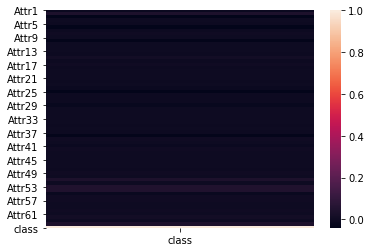

In [9]:
sns.heatmap(df.corr()[["class"]]) #Features aren't too correlated to target, we must find the relationships between them.

In [10]:
print(df["class"].value_counts())
print(df.dropna()["class"].value_counts())

#We see that the dataset is very uneven, we'll impute some data and use smote to make it more even.

False    9773
True      400
Name: class, dtype: int64
False    4015
True       73
Name: class, dtype: int64


In [11]:
print("Total missing values: ", df.isna().sum().sum()) 
print("Missing values in True target: ",df[df["class"]].isna().sum().sum()) 

#The missing values in the second target aren't too many, we can imput them.

Total missing values:  12157
Missing values in True target:  679


In [12]:
imp_mean = Imputer(strategy="mean")           #Instancing the imputer for using it on the true class
imp_df = df[df["class"]]                      #Get the values we want to imput
transformed = imp_mean.fit_transform(imp_df)  #Imputting data

In [13]:
df_imput = pd.DataFrame(transformed,columns = df.columns)    #We make it a dataframe again for proper handling
df_to_model = df[df["class"].apply(lambda x: not x)]         #And select only the data needed
df_to_model = df_to_model.append(df_imput)

In [14]:
df_to_model.dropna()["class"].value_counts()  #Check for consistency in imputting

0.0    4015
1.0     400
Name: class, dtype: int64

In [15]:
#Train test split, so we don't smote the test
X = df_to_model.dropna().drop(["class"],axis=1)
y = df_to_model.dropna()["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)       
y_train = np.ravel(y_train)


In [16]:
#Applying smote for balancing the data
sm = SMOTE()
X_train , y_train = sm.fit_sample(X_train,y_train)
pd.DataFrame(y_train)[0].value_counts() #We check the data is balanced

1.0    2999
0.0    2999
Name: 0, dtype: int64

C:\Users\Negro\.conda\envs\Smote\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC Acc: 0.5561594202898551
Accuracy of Decision tree:	0.946 ± 0.005


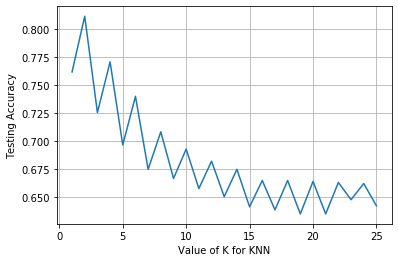

In [17]:
#We do our first model fit using LinearSVC,KNeighbors and Decision Forests to see how they work


#SVC
model = SVC(random_state=0,max_iter=10000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('SVC Acc:' ,metrics.accuracy_score(y_test, y_pred))

#KNeighbors
k_range = np.arange(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

# Plotting Value of K to Testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.grid(True)


#Decision tree

cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1)

print("Accuracy of {}:\t{:0.3} ± {:0.3}".format( \
        "Decision tree", s.mean().round(3), s.std().round(3)))

Given that SVC doesn't converge even when using 10000 iterations and the accuracy isn't pretty good, seems like a good idea to use other model.

With Knn we get a maximum of ~0.84 accuracy, by the drastic changes in the accuracy of the models, we can infer that the bias of unbalanced data has been solved, but let's check the confusion matrix of every model.

Because we aren't using any tools to correlate data, trees are giving a good result, since it's able to correlate data inside the model and find intrinsic relationships between the features.

In [18]:
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

Text(0.5, 1, 'Decision Trees')

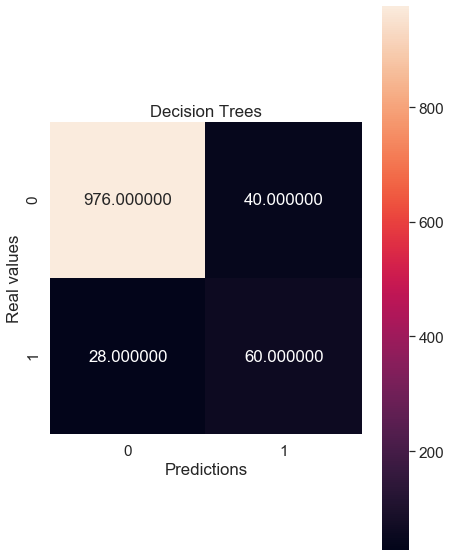

In [19]:
plt.figure(figsize = (7,10))
sns.set(font_scale=1.4)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred),annot=True,fmt="f",square=True)
plt.autoscale()
plt.ylabel('Real values')
plt.xlabel('Predictions')
plt.title("Decision Trees")

In [20]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Text(0.5, 1, 'KN')

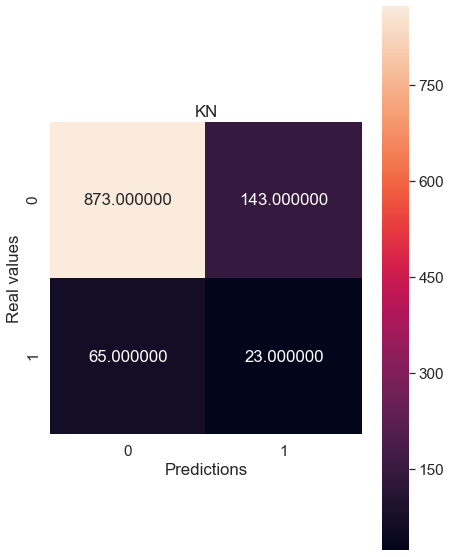

In [21]:
plt.figure(figsize = (7,10))
sns.set(font_scale=1.4)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred),annot=True,fmt="f",square=True)
plt.autoscale()
plt.ylabel('Real values')
plt.xlabel('Predictions')
plt.title("KN")

In [22]:
y_pred = model.predict(X_test)

Text(0.5, 1, 'SVC')

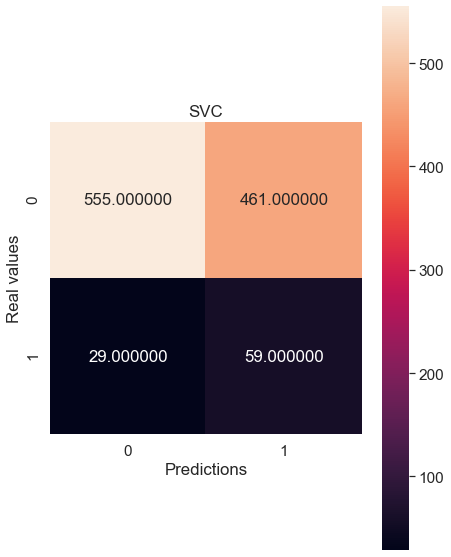

In [23]:
plt.figure(figsize = (7,10))
sns.set(font_scale=1.4)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred),annot=True,fmt="f",square=True)
plt.autoscale()
plt.ylabel('Real values')
plt.xlabel('Predictions')
plt.title("SVC")

Let's try only using balanced weights in Decision trees:

In [24]:
df_to_model.dropna()["class"].value_counts()

0.0    4015
1.0     400
Name: class, dtype: int64

In [25]:
#Train test split
X = df_to_model.dropna().drop(["class"],axis=1)
y = df_to_model.dropna()["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)       
y_train = np.ravel(y_train)

cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)      #Using cross validation
dt = DecisionTreeClassifier(class_weight={0:9,1:1})                  #Adding the class weight
s = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1)

print("Accuracy of {}:\t{:0.3} ± {:0.3}".format( \
        "Decision tree", s.mean().round(3), s.std().round(3)))

Accuracy of Decision tree:	0.951 ± 0.009


Seems pretty good, let's see the confusion matrix

In [26]:
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

Text(0.5, 1, 'Decision Trees')

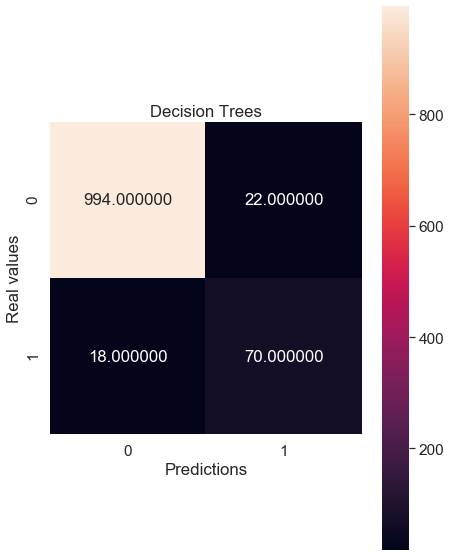

In [27]:
plt.figure(figsize = (7,10))
sns.set(font_scale=1.4)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred),annot=True,fmt="f",square=True)
plt.autoscale()
plt.ylabel('Real values')
plt.xlabel('Predictions')
plt.title("Decision Trees")

In [28]:
print(pd.Series(y_test).value_counts()) #Checking how many class 1 elements we have in our test

0.0    1016
1.0      88
Name: class, dtype: int64


Given that we can predict successfully 70 cases out of 88 we see that the model is indeed working well, now we can use df.predict_proba() to predict the probability of bankruptcy

In [29]:
dt.predict_proba

<bound method DecisionTreeClassifier.predict_proba of DecisionTreeClassifier(class_weight={0: 9, 1: 1}, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')>

To conclude, given the small amount of data related to company bankruptcy (400) more research could be needed.
Some possible routes of action to get a better score, simplifying our model and decreasing the amount of needed data are:

- Feature selection, PCA
    - Because some features are related to eachother as seen in the final heatmap
- Standarizing features
- Checking for other methods of undersampling and oversampling
- Using other models like catboost or randomforests
- Applying Gridsearch and Randomsearch

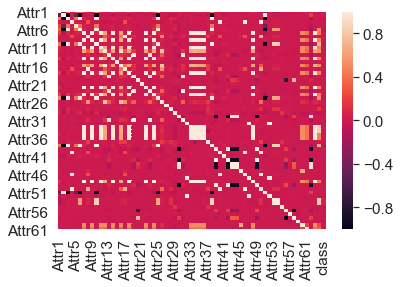

In [30]:
sns.heatmap(df.corr())